## Introduction to FALQON

In this demo, we'll be implement the FALQON algorithm, standing for *Feedback-based ALgorithm for Quantum OptimizatioN*, introduced by [Magann, Rudinger, Grace & Sarovar (2021)](https://arxiv.org/pdf/2103.08619.pdf). It is similar in spirit to the [QAOA](https://arxiv.org/pdf/1411.4028.pdf), but scales with resources differently, using iterative feedback steps rather than a global optimization over parameters. We will show how to implement FALQON in PennyLane and test its performance on the **MaxClique** problem in graph theory!

### Theory

To solve combinatorial optimization problems using a quantum computer, a typical strategy is to encode the solution to the problem as the ground state of *cost Hamiltonian* $H_C$, and choose some strategy to drive the system from a known initial state into this ground state. FALQON falls under this broad scheme. The driving strategy is implemented with a *driving Hamiltonian* $H_D$ with a single control parameter $\beta(t)$, so the system evolves according to

$$
i\partial_t |\psi(t)\rangle = (H_C + \beta(t) H_D) |\psi(t)\rangle,
$$

setting $\hbar = 1$. We would ultimately like to minimize the expectation value of $\langle H_C\rangle$, so a reasonable driving strategy is simply to decrease this expectation with time:

$$
\partial_t \langle H_C\rangle_t = \partial_t \langle \psi(t)|H_C|\psi(t)\rangle = i \beta(t)\langle [H_D, H_C] \rangle_t \leq 0,
$$

where we used the product rule and Schrödinger's equation. An easy way to satisfy this equation is to pick $\beta(t) = -\langle i[H_D, H_C] \rangle_t$, so that

$$
\partial_t \langle H_C\rangle_t = -|\langle i[H_D, H_C] \rangle_t|^2 \leq 0.
$$

(Note that we bring the $i$ into the expectation to give a Hermitian operator.)
Using techniques from [control theory](https://arxiv.org/pdf/1304.3997.pdf), it is possible to show this will eventually drive the system into the ground state. But there are two issues: (a) first, we need to somehow *evaluate* the expectation $A(t) := i\langle [H_D, H_C] \rangle_t$ to implement the driving strategy, and (b) we must do so continuously in time! This seems rather impractical. In order to solve the first problem, we can perform a [Trotter-Suzuki](https://en.wikipedia.org/wiki/Lie_product_formula) decomposition of the time evolution operator $|\psi(t)\rangle = U(t)|\psi_0\rangle$:

$$
U(t) \approx U_D(\beta_\ell) U_C U_D(\beta_{\ell-1}) U_C\cdots
U_D(\beta_1) U_C, \quad U_C = e^{-iH_C \Delta t}, \quad U_D(\beta_k) =
e^{-i\beta_k H_D \Delta t},
$$

where $\Delta t = t/2\ell$ and $\beta_k = \beta(2k\Delta t)$. Our discrete-time driving strategy is to use the value of $A(t)$ at the previous time-step:

$$
\beta_{k+1} = -A_k = -A(2k\Delta t).
$$

This leads immediately to the FALQON algorithm. On step $k$, we perform the following three substeps:

1. Prepare the state $|\psi_k\rangle = U_D(\beta_k) U_C \cdots U_D(\beta_1) U_C|\psi_0\rangle$,
2. Measure the expectation value $A_k = \langle i[H_C, H_D]\rangle_k$.
3. Set $\beta_{k+1} = -A_k$.

Provided $\Delta t$ is small enough to ensure negligible error in our Trotter-Suzuki decomposition, after enough steps we will approach the ground state. How small $\Delta t$ needs to be, and how large $\ell$, are fiddly and problem-dependent questions we won't get into now. Is this a good algorithm? One simple measure is the *sampling complexity* $N_S$, the number of times we need to run a circuit (ignoring the resources required by the circuit itself). This will obviously depend on

- the number of samples $s$ required to perform a single measurement of $i[H_C, H_D]$;
- the number of measurements $m$ we want to take in order to approximate the expectation $\langle i[H_C, H_D]\rangle$;  and
- the total number of steps $\ell$.

Multiplying these gives a rough estimate for the sampling complexity $N_s = \mathcal{O}(sm\ell)$. We can contrast this with QAOA, which optimizes $\langle H_C\rangle$ over $2\ell$ parameters (since it modulated the cost Hamiltonian as well). If it uses gradient descent, then each paramter will require separate circuit runs, leading to sampling complexity $N_S = \mathcal{O}(qm\ell)$, where $q$ is the number of runs needed for the classical optimization protocol. This suggests that FALQON is favorable when $s \leq q$, i.e. it takes fewer circuit calls to measure $i[H_C, H_D]$ than it does to classically optimize a single parameter.

### A flightless FALQON in PennyLane

Before launching into a concrete problem, let's describe how to set up the general FALQON algorithm in PennyLane. The code will be illustrative and not executable, but will prepare us for the next section. FALQON shares many structural characteristics with [QAOA](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html), and in fact, we can use it to perform the subroutines for FALQON! We recommend looking at that tutorial for further background information. Let's start by defining the cost and driving Hamiltonians using PennyLane's `Hamiltonian` operation. We also will typically need to put in the commutator by hand:

In [3]:
import pennylane as qml

cost_H = qml.Hamiltonian(
    # your cost Hamiltonian H_C goes here
)

drive_H = qml.Hamiltonian(
    # your driving Hamiltonian H_D goes here
)

comm_H = qml.Hamiltonian(
    # your commutator i[H_C, H_D] goes here
)

For step $k$ of FALQON, we prepare state $|\psi_\rangle$ by applying $k$ layers, with each layer consisting of a cost step (dependent on $\Delta t$), and then a driving step (dependent on both $\Delta t$ and $\beta$). We can code this using the `cost_layer()` and `mixer_layer()` methods from the QAOA module, which we first import:

In [ ]:
from pennylane import qaoa

def falqon_layer(beta, delta_t):
    qaoa.cost_layer(delta_t, cost_h)
    qaoa.mixer_layer(delta_t*beta, drive_h)

We then apply these layers $k$ times using the `layer()` method, and using the iteratively generated list of $\beta$ values so far:

In [ ]:
def falqon_circuit(step, beta_list, delta_t):
    # initial state preparation
    qml.layer(falqon_layer, step, beta_list, delta_t)

Finally, to determine the next $\beta$ value, we need to measure the commutator $i[H_C, H_D]$. We run a device on the QULACS simulator, which is designed for large parametric circuits, and append the resulting value of $\beta$ to an input list of values given so far:

In [ ]:
dev = qml.device("qulacs.simulator", wires=wires)

def add_beta(step, beta_list, delta_t):
    A = qml.ExpvalCost(circuit(beta_list, delta_t), comm_h, dev)
    return beta_list.append(-A)        

This computes the expectation of $A_k$ exactly, but on a real device we will have to think much more carefully about how to measure the commutator. Finally, we iterate and produce as an output the estimated cost $\langle H_C\rangle_\ell$ and the resulting sequence $\{\beta_k\}$ which generates our state:

In [ ]:
def falqon(ell, delta_t):
    beta_list = [0]
    for step in range(ell):
        beta_list = add_beta(step, beta_list, delta_t)
    min_cost = qml.ExpvalCost(circuit(beta_list, delta_t), cost_h, dev)
    return (min_cost, beta_list)

Let's see how this works on a real example!

### Benchmarking FALQON for MaxClique

Let's make some data to compare FALQON to. We will generate random *Erdös-Renyi graphs* $G_{n, p}$, obtained by keeping any given edge in the complete graph $K_n$ with probability $p$ (independent of the others). Here is a function for making them.

In [1]:
import networkx as nx
import numpy as np

def erdos_renyi(n, p):
    edges = []
    graph = nx.Graph()
    graph.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i + 1, n):
            if np.random.rand() < p:
                edges.append((i, j))
    graph.add_edges_from(edges)
    return graph

To solve MaxClique, we'll use the [Bron-Kerbosch algorithm](https://en.wikipedia.org/wiki/Bron%E2%80%93Kerbosch_algorithm) without pivoting. Here is a simple Python implementation:

In [2]:
def bron_kerbosch(graph):
    
    all_nodes_init = []
    some_nodes_init = list(graph.nodes())
    no_nodes_init = []
    
    max_clique_list = []
    
    def bk_subroutine(all_nodes, some_nodes, no_nodes):
        if (some_nodes + no_nodes == []):
            max_clique_list.append(all_nodes)
        else:
            for v in some_nodes:
                neighbs = list(graph.neighbors(v))
                new_some_nodes = list(set(some_nodes) & set(neighbs))
                new_no_nodes = list(set(no_nodes) & set(neighbs))
                some_nodes.remove(v)
                no_nodes.append(v)
                bk_subroutine(all_nodes + [v], new_some_nodes, new_no_nodes)
    
    bk_subroutine(all_nodes_init, some_nodes_init, no_nodes_init)
    
    return max_clique_list

Let's check this works with a simple example:

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


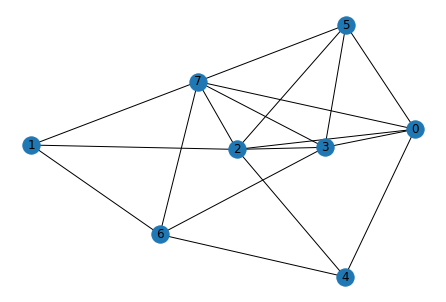

In [3]:
graph = erdos_renyi(8, 0.5)
nx.draw(graph,with_labels=True)

In [4]:
bron_kerbosch(graph)

[[0, 2, 3, 5, 7], [2, 1, 7], [4, 6], [6, 1, 7], [6, 7, 3]]

So, this appears to be giving us sensible results! Now, these cliques are maximal in the sense they cannot be extended, but not the largest cliques. To do this, we simply maximize the length of cliques.

In [5]:
def largest_clique(graph, clique_list = 0):
    largest_cliques = []
    maximal_cliques = bron_kerbosch(graph)
    largest = max([len(clique) for clique in maximal_cliques])
    if clique_list == 0:
        return largest, []
    else:
        return largest, [clique for clique in maximal_cliques if (len(clique) == largest)]

largest_clique(graph, 1)

(5, [[0, 2, 3, 5, 7]])

It's working, yay! This means we can now generate a data set for benchmarking the performance of FALQON. What we will do is pick some some list of node sizes, generate some random, relatively sparse graphs (small probability), and then solve for the MaxClique. Since we would like to check that FALQON (or birdseed) are giving correct answers, we will generate the clique list as well as the largest clique size. Our choice of parameters will initially be guided by computational convenience. Our approach will be to create a Python dictionary, whose keys are sizes and whose entries are lists of graphs and solutions to the MaxClique problem.

In [13]:
size_list = range(6, 12, 2)
graphs_per_size = 2
prob = 0.1

maxclique_dataset = {}

for size in size_list:
    maxclique_dataset[size] = []
    for reps in range(graphs_per_size):
        graph = erdos_renyi(size, prob)
        solution = largest_clique(graph, 1)
        maxclique_dataset[size].append((graph, solution))

We're almost ready! Let's adapt Jack's awesome code to see how do we against our benchmark set. It's more or less the same except we've made `graph` an input to all the procedures.

In [9]:
import pennylane as qml
from pennylane import qaoa as qaoa

def build_commutator(graph):
    
    H = qml.Hamiltonian([], [])
    
    # Computes the complement of the graph
    graph_c = nx.complement(graph)
    
    
    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)
    
    return H

# Define a layer of the Falqon circuit

def falqon_layer(beta):
    qaoa.cost_layer(delta_t, cost_h)
    qaoa.mixer_layer(delta_t * beta, driver_h)

def ansatz(beta, wires, **kwargs):
    layers = len(beta)
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(falqon_layer, layers, beta)
    
def falqon(iterations, beta_init, dev):
    
    beta = [beta_init]
    energies = []
    
    for i in range(iterations):
        cost_fn = qml.ExpvalCost(ansatz, hamiltonian, dev)
        cost_fn_energy = qml.ExpvalCost(ansatz, cost_h, dev)
        
        beta.append(-1 * cost_fn(beta))
        energy = cost_fn_energy(beta)
        energies.append(energy)
        
        # print("Step {} Done, Cost = {}".format(i, energy))
    
    return beta, energies

Our goal now is to apply FALQON to the MaxClique dataset we generated. In order to measure the performance, we will use the same figures of merit from the paper. The first is $r_A = (\langle H_C\rangle - \langle H_C\rangle_\text{min})/|\langle H_C\rangle_\text{min}|$, the relative error in our guess for the minimimum. To compute this, we note that for the Hamiltonian

$$
H_C = 3 \sum_{(i,j)\in E(\bar{G})} (Z_i Z_j- Z_i - Z_j) + \sum_{i\in V(G)} Z_i,
$$

a clique $K$ corresponds to a vertex set $V(K)$ which is "spin down", $Z_k = -1$ for $k \in V(K)$, so the second term gives $n - 2k$, where $n = |V(G)|$ and $k = |V(K)|$. The first term sums over edges in the complementary graph. The remaining vertices have $Z_k = +1$, so every non-edge between vertices outside of $K$ contributes $3(1^2 - 1 - 1) = -3$. On the other hand, non-edges between clique and non-clique vertices contribute $3(1(-1) - 1 + 1) = -3$. So every non-edge contributes $-3$, and our minimal cost is

$$
\langle H_C\rangle = -\frac{3}{2}[n(n- 1) - |E(G)|] + n - 2k.
$$

The other figure of merit is the overlap between the FALQON guess $|\psi\rangle$ and the ground state $|\psi_K\rangle$ we have just described. If the cliques are not unique, this ground state will not be unique, but because the cliques are disjoint, we can simply define a sum over largest cliques,

$$
\phi = \sum_K |\langle \psi| \psi_K\rangle|^2.
$$

Below, we write function to compute these two figures of merit. Note that we will obtain probabilities rather than amplitudes after our run, and since the cliques are disjoint, we can simply add the corresponding probabilities.

In [10]:
def rA(graph, guess):
    
    k = largest_clique(graph)[0]
    n = len(graph.nodes())
    min_HC = -(3/2)*(n*(n-1) - len(graph.edges())) + n - 2*k
    
    return (guess - min_HC)/abs(min_HC)

def phi(graph, probs):
    
    # Define a function to convert a clique to a basis element
    
    def convert(clique):
        basis_num = 0
        for n in clique:
            basis_num += 2**n
        return basis_num
        
    phi = 0
    cliques = largest_clique(graph, clique_list = 1)[1]
    for clique in cliques:
        for i in range(len(probs)):
            phi += probs[convert(clique)]
            
    return phi

Finally, we can plot how $\beta$, $r_A$, and $\phi$ behave as functions of layer, with different curves corresponding to averages over different graph size.

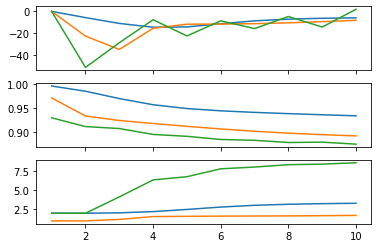

In [21]:
import matplotlib.pyplot as plt

# initialize hyperparameters
delta_t = 0.01
beta_init = 0.0
layers = 10

sizes = list(maxclique_dataset.keys())

# create empty dicts to store data by graph size
beta_vals = {}
rA_vals = {}
phi_vals = {}

for size in sizes:
    
    # create empty entries for layers
    beta_vals[size] = [0] * layers
    rA_vals[size] = [0] * layers
    phi_vals[size] = [0] * layers
    
    # iterate over graphs of given size in data set
    
    for entry in range(graphs_per_size):

        # run FALQON to generate betas and energies
        graph = maxclique_dataset[size][entry][0]
        dev = qml.device("default.qubit", wires=graph.nodes)
        hamiltonian = build_commutator(graph)
        cost_h, driver_h = qaoa.max_clique(graph, constrained=False)
        res, res_energies = falqon(layers, beta_init, dev)
        
        # for each layer, compute phi, r_A and add
        for layer in range(layers):
            
            betas = res[:layer] # betas so far
            energy = res_energies[layer] # current energy estimate
            
            @qml.qnode(dev)
            def run_falqon():
                ansatz(betas, wires=dev.wires)
                return qml.probs(wires=dev.wires)

            probs = run_falqon()
            float_probs = [float(x) for x in probs]
        
            beta_vals[size][layer] += res[layer]/graphs_per_size
            rA_vals[size][layer] += rA(graph, energy)/graphs_per_size
            phi_vals[size][layer] += phi(graph, float_probs)/graphs_per_size

layer_vals = range(1, layers+1)

fig, axs = plt.subplots(3, sharex=True)
axs[0].set_title("β as a function of layer")
axs[0].xlabel("β")
axs[0].ylabel("layer")
axs[1].set_title("r_A as a function of layer")
axs[1].xlabel("r_A")
axs[1].ylabel("layer")
axs[2].set_title("ϕ as a function of layer")
axs[2].xlabel("ϕ")
axs[2].ylabel("layer")

for size in sizes:
    
    axs[0].plot(layer_vals, beta_vals[size], label=)
    axs[1].plot(layer_vals, rA_vals[size])
    axs[2].plot(layer_vals, phi_vals[size])
    
plt.show()

### Extra stuff on randomness (not needed)

We will feed these random graphs into our algorithm. In order to benchmark performance, we compare to the typical largest clique size. This is discussed in, e.g., section 7.2 of [Frieze and Karonski (2015)](https://www.math.cmu.edu/~af1p/BOOK.pdf), though we have to take $p \to 1- p$ in order to exchange independent graphs for cliques. The famous result of [Matula (1976)](https://s2.smu.edu/~matula/Tech-Report76.pdf) is that the size of the largest clique $\alpha(G)$ obeys

$$
\alpha(G_{n,p}) \approx 2 \log_{1/p} n
$$

with probability $1$ as $n\to \infty$. For sparse graphs with $p = 1 - d/n$ ($d$ fixed), we have

$$
\alpha(G_{n,p}) \approx \frac{2 d\log n}{d}.
$$

We will take $n$ relatively small and hope it all works! We probably should just use the regular result since we will not be exploiting the nontrivial limit for sparseness. (In fact, this whole approach is suspicious for the graphs we'll be using, but let's just see how it goes.)

In [82]:
def er_alpha_dense(n, p):
    return 2*np.log(n)/np.log(1/p)

def er_alpha_sparse(n, d):
    return 2*d*np.log(n)/d

One question we can now address: how accurate is the Erdös-Renyi value for small graphs?

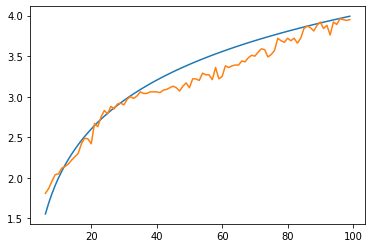

In [105]:
from matplotlib import pyplot as plt

def emp_alpha(size, prob, samples):
    max_sizes = []
    for i in range(samples):
        graph = erdos_renyi(size, prob)
        max_size = largest_clique(graph, 0)[0]
        max_sizes.append(max_size)
    return sum(max_sizes)/samples

samples = 100
prob = 0.1

size_vals = range(6, 100)
er_vals = [er_alpha_dense(size, prob) for size in size_vals]
emp_vals = [emp_alpha(size, prob, samples) for size in size_vals]

plt.plot(size_vals, er_vals)
plt.plot(size_vals, emp_vals)

In [27]:
delta_t = 0.03
beta_init = 0.0

averages = []

for n in maxclique_dataset.keys():
    max_cliques = []
    for graph in maxclique_dataset[n]:
        dev = qml.device("default.qubit", wires=graph.nodes)
        hamiltonian = build_commutator(graph)
        cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

        res, res_energies = falqon(iterations, beta_init, dev)
        
        @qml.qnode(dev)
        def test_circuit():
            ansatz(res, wires=dev.wires)
            return qml.probs(wires=dev.wires)

        probs = test_circuit()
        convert_to_floats = [float(x) for x in probs]
        max_value = max(convert_to_floats)
        sol_number = convert_to_floats.index(max_value)
        basis_element = bin(sol_number)[2:]
        max_clique_size = sum([int(c) for c in basis_element])
        
        max_cliques.append(max_clique_size)

    avg = sum(max_cliques)/graphs_per_size
    averages.append(avg)

Let's divide these results by the Erdös-Renyi result to obtain a lazy figure of merit:

In [ ]:
er_max = [er_alpha_dense(n, prob) for n in n_list]
figure_of_merit = [averages[i]/er_max[i] for i in range(len(n_list))]
plt.plot(n_list, figure_of_merit)